# Get and Format data 

In [21]:
from tqdm import tqdm
import gzip
import os
import shutil
import urllib.request
import requests
import json
import io
import pandas as pd
import numpy as np
import rampwf as rw
from rampwf.workflows.sklearn_pipeline import SKLearnPipeline, Estimator
from rampwf.prediction_types import make_regression
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import folium

from problem import *

In [22]:
X_train, Y_train = get_train_data()
X_test, Y_test = get_test_data()

In [23]:
X_train.head()

,tr002_type_batiment_id,secteur_activite,tr012_categorie_erp_id,tr013_type_erp_id,annee_construction,surface_habitable,surface_thermique_lot,tv016_departement_id,commune,arrondissement,...,tv017_zone_hiver_code,tv017_zone_hiver_t_ext_moyen,tv017_zone_hiver_peta_cw,tv017_zone_hiver_dh14,tv017_zone_hiver_prs1,tv018_zone_ete_code,tv018_zone_ete_sclim_inf_150,tv018_zone_ete_sclim_sup_150,tv018_zone_ete_rclim_autres_etages,tv018_zone_ete_rclim_dernier_etage
id,,,,,,,,,,,,,,,,,,,,,
10408629,4,\N,5,\N,1947,110.00,110.00,62,AIRE SUR LA LYS,None,...,H1,6.58,10.5,42030,3.6,Ea,2,4,1.5,2
48420,4,tabac presse,\N,\N,1974,164.24,164.24,59,CAPPELLE-LA-GRANDE,00,...,H1,6.58,10.5,42030,3.6,Ea,2,4,1.5,2
7710054,4,"Bureau, Administration, Enseignement",\N,\N,1947,164.56,164.56,75,PARIS 03,None,...,H1,6.58,10.5,42030,3.6,Eb,3,5,2.0,3
11399812,4,None,\N,\N,1970,0.00,0.00,60,BEAUVAIS,00,...,H1,6.58,10.5,42030,3.6,Ea,2,4,1.5,2
7837691,4,None,\N,12,1980,0.00,0.00,43,BRIVES-CHARENSAC,00,...,H1,6.58,10.5,42030,3.6,Ec,4,6,3.0,4


In [24]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130937 entries, 10408629 to 6708173
Columns: 103 entries, tr002_type_batiment_id to tv018_zone_ete_rclim_dernier_etage
dtypes: float64(20), int64(20), object(63)
memory usage: 103.9+ MB


In [25]:
Y_train.head()

,classe_consommation_energie,classe_estimation_ges
id,,
10408629,D,C
48420,D,D
7710054,C,D
11399812,D,B
7837691,D,D


In [26]:
X_train.shape

(130937, 103)

In [27]:
X_test.shape

(56116, 103)

In [28]:
Y_train.shape

(130937, 2)

In [29]:
Y_test.shape

(56116, 2)

In [30]:
df_train = pd.concat([X_train, Y_train], axis=1)
df_test = pd.concat([X_test, Y_test], axis=1)

df = pd.concat([df_train, df_test], axis=0)

In [31]:
df_train.shape

(130937, 105)

# Statistics

In [32]:
df.describe()

,tr002_type_batiment_id,annee_construction,tv016_departement_id,etat_avancement,est_efface,longitude,latitude,geo_score,tr002_type_batiment_est_efface,tr002_type_batiment_ordre,...,tv016_departement_fecs_ancienne_i_c,tv016_departement_fecs_recente_i_c,tv017_zone_hiver_t_ext_moyen,tv017_zone_hiver_peta_cw,tv017_zone_hiver_dh14,tv017_zone_hiver_prs1,tv018_zone_ete_sclim_inf_150,tv018_zone_ete_sclim_sup_150,tv018_zone_ete_rclim_autres_etages,tv018_zone_ete_rclim_dernier_etage
count,187053.000000,187053.000000,187053.000000,187053.0,187053.0,187053.000000,187053.000000,187053.000000,187053.0,187053.000000,...,187053.000000,187053.000000,187053.000000,187053.000000,187053.000000,187053.000000,187053.000000,187053.000000,187053.000000,187053.000000
mean,4.025164,1965.262225,55.993665,1.0,0.0,2.718157,47.214891,0.815826,0.0,4.974836,...,29.717075,42.759956,7.258081,11.260554,37909.521419,3.483813,3.319220,5.319220,2.406716,3.319220
std,0.156623,77.670844,25.487928,0.0,0.0,2.742295,2.093733,0.210064,0.0,0.156623,...,4.790128,8.696925,0.992353,1.203829,6205.918603,0.201932,0.885804,0.885804,0.768040,0.885804
min,4.000000,-1.000000,1.000000,1.0,0.0,-61.525777,16.415924,0.300000,0.0,4.000000,...,24.000000,0.000000,6.580000,10.500000,22200.000000,2.900000,2.000000,4.000000,1.500000,2.000000
25%,4.000000,1947.000000,35.000000,1.0,0.0,1.149685,45.744920,0.690000,0.0,5.000000,...,26.000000,38.000000,6.580000,10.500000,33300.000000,3.400000,3.000000,5.000000,2.000000,3.000000
50%,4.000000,1969.000000,62.000000,1.0,0.0,2.408653,47.769940,0.950000,0.0,5.000000,...,28.000000,41.000000,6.580000,10.500000,42030.000000,3.600000,3.000000,5.000000,2.000000,3.000000
75%,4.000000,1989.000000,75.000000,1.0,0.0,4.861759,48.865288,0.970000,0.0,5.000000,...,32.000000,46.000000,8.080000,12.000000,42030.000000,3.600000,4.000000,6.000000,3.000000,4.000000
max,5.000000,20011.000000,97.000000,1.0,0.0,9.551810,51.080627,0.990000,0.0,5.000000,...,43.000000,62.000000,9.650000,14.500000,42030.000000,3.600000,5.000000,7.000000,4.000000,5.000000


In [33]:
# keep column with int type
df_filtered_float = df.select_dtypes(include=["int", "float"])
df_filtered_float.shape

(187053, 40)

In [34]:
df_filtered_float.columns

Index(['tr002_type_batiment_id', 'annee_construction', 'tv016_departement_id',
       'etat_avancement', 'est_efface', 'longitude', 'latitude', 'geo_score',
       'tr002_type_batiment_est_efface', 'tr002_type_batiment_ordre',
       'tr002_type_batiment_simulateur', 'tr012_categorie_erp_est_efface',
       'tr013_type_erp_categorie_id', 'tr013_type_erp_est_efface',
       'tv017_zone_hiver_id', 'tv018_zone_ete_id', 'tv016_departement_altmin',
       'tv016_departement_altmax', 'tv016_departement_nref',
       'tv016_departement_dhref', 'tv016_departement_pref',
       'tv016_departement_c2', 'tv016_departement_c3', 'tv016_departement_c4',
       'tv016_departement_t_ext_basse', 'tv016_departement_e',
       'tv016_departement_fch', 'tv016_departement_fecs_ancienne_m_i',
       'tv016_departement_fecs_recente_m_i',
       'tv016_departement_fecs_solaire_m_i',
       'tv016_departement_fecs_ancienne_i_c',
       'tv016_departement_fecs_recente_i_c', 'tv017_zone_hiver_t_ext_moyen',
     

# Features description

- annee_construction : year of construction of the building
- surface_habitable : the surface which is habitable in $m^2$     
- surface_thermique_lot : measures the quantity of heat necessary to maintain a given temperature on the building 
- surface_commerciale_contractuelle : the sales area in $m^2$ that is leased or made available by the owner of a commercial property to a tenant     
- shon : measures the surface in $m^2$ of all the closed and covered premises of a building, intended to be occupied (residential premises, offices, shops, etc.)
- surface_utile : measure in $m^2$ calculated by deducting from the living area the parts of the area that cannot be used for human occupation, such as walls, partitions, posts, stairwells, service shafts, lost attic space, etc. In other words, the useful surface measures the actual surface available for the occupant's activities.
- surface_thermique_parties_communes : the surface area in $m^2$ of the common parts of a building, such as lobbies, staircases, corridors, cellars and parking lots, which have an impact on the building's energy consumption
- nombre_niveaux : number of floors
- surface_verriere : the surface in $m^2$ of the glazed elements of a construction, such as windows, French windows, bay windows, glass roofs, glazing of verandas, etc.                     
- nombre_entrees_avec_sas : the number of entrances of a building that are equipped with an airlock. An airlock is an enclosed space between the exterior and interior of a building, which limits heat loss and air infiltration
- nombre_entrees_sans_sas : the number of entrances of a building that are **NOT** equipped with an airlock. An airlock is an enclosed space between the exterior and interior of a building, which limits heat loss and air infiltration
- surface_baies_orientees_nord : area of glazed elements in a building, such as windows, patio doors, bay windows, skylights, conservatory glazing, etc., that face **NORTH** in $m^2$
- surface_baies_orientees_est_ouest : area of glazed elements in a building, such as windows, patio doors, bay windows, skylights, conservatory glazing, etc., that face **EAST or WEST** in $m^2$
- surface_baies_orientees_sud : area of glazed elements in a building, such as windows, patio doors, bay windows, skylights, conservatory glazing, etc., that face **SOUTH** in $m^2$
- surface_planchers_hauts_deperditifs : the surface of floors in $m^2$ separating heated premises from unheated premises, such as lost attics, basements, garages or courtyards, which are considered as thermal buffer zones.
- surface_planchers_bas_deperditifs :  the surface area of floors separating heated premises from the ground or crawl space, which are considered as thermal buffer zones.
- surface_parois_verticales_opaques_deperditives : the surface of exterior or interior walls of a building that are in direct contact with the outside air or unheated premises, such as cellars, garages or basements in $m^2$
- longitude : longitude
- latitude : latitude


In [35]:
df.dtypes

tr002_type_batiment_id                  int64
secteur_activite                       object
tr012_categorie_erp_id                 object
tr013_type_erp_id                      object
annee_construction                      int64
                                       ...   
tv018_zone_ete_sclim_sup_150            int64
tv018_zone_ete_rclim_autres_etages    float64
tv018_zone_ete_rclim_dernier_etage      int64
classe_consommation_energie            object
classe_estimation_ges                  object
Length: 105, dtype: object

# Look at NaN

<Axes: ylabel='id'>

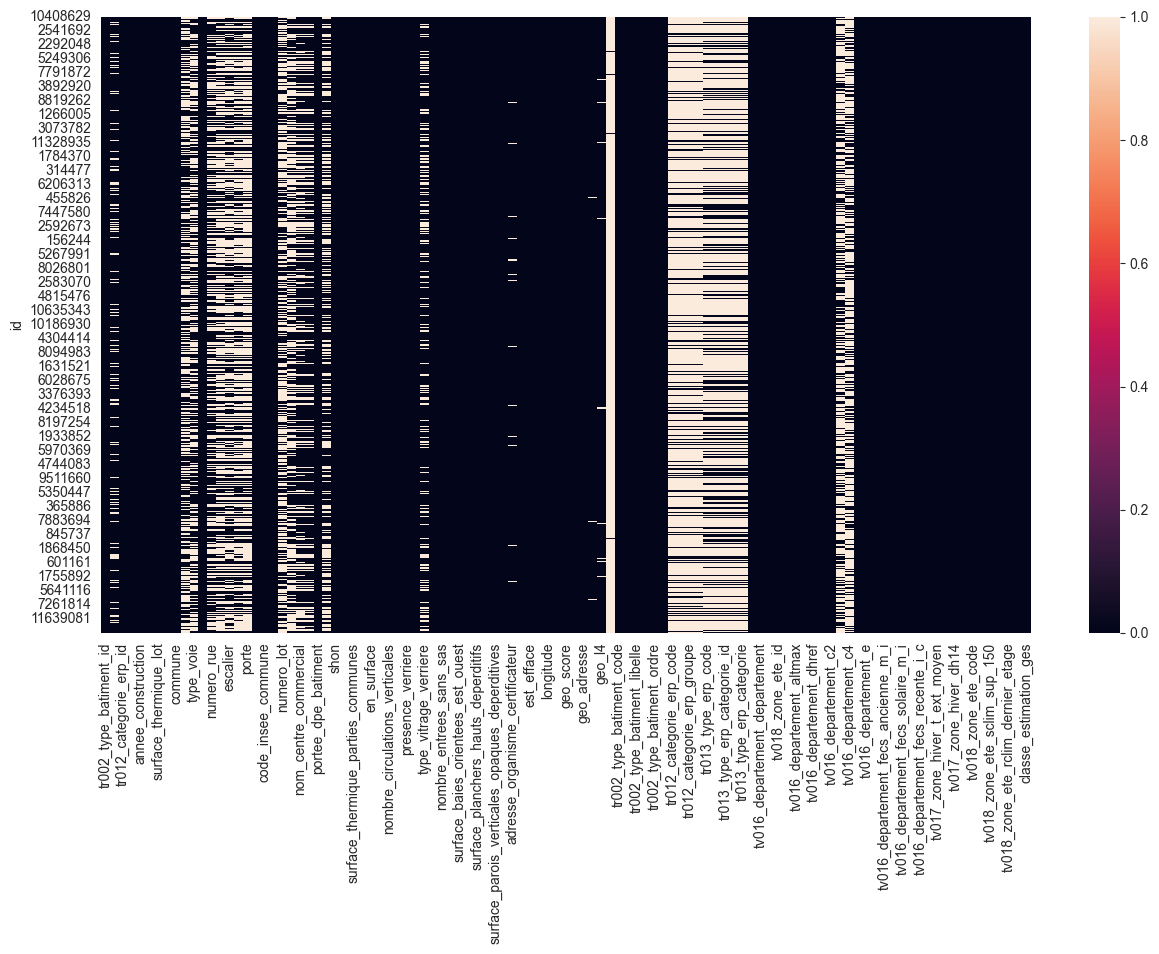

In [36]:
plt.figure(figsize=(15, 8))
sns.heatmap(df.isna())

# Plot interactive map

In [37]:
dpe = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs=4326
)
dpe = dpe.dropna(subset=["longitude", "latitude"])

In [38]:
palette = sns.color_palette("coolwarm", 8)


def interactive_map_dpe(dpe):
    # convert in number
    dpe["color"] = [
        ord(dpe.iloc[i]["classe_consommation_energie"].lower()) - 96
        for i in range(len(dpe))
    ]
    dpe = dpe.loc[dpe["color"] <= 7]
    dpe["color"] = [palette.as_hex()[x] for x in dpe["color"]]

    center = dpe[["latitude", "longitude"]].mean().values.tolist()
    sw = dpe[["latitude", "longitude"]].min().values.tolist()
    ne = dpe[["latitude", "longitude"]].max().values.tolist()

    m = folium.Map(location=center, tiles="Stamen Toner")

    # I can add marker one by one on the map
    for i in range(0, len(dpe)):
        folium.Marker(
            [dpe.iloc[i]["latitude"], dpe.iloc[i]["longitude"]],
            popup=f"Année de construction: {dpe.iloc[i]['annee_construction']}, <br>DPE: {dpe.iloc[i]['classe_consommation_energie']}",
            icon=folium.Icon(
                color="black", icon="home", icon_color=dpe.iloc[i]["color"]
            ),
        ).add_to(m)

    m.fit_bounds([sw, ne])

    return m


m = interactive_map_dpe(dpe.head(10))

/Users/guillaumephilippe/own-ramp-kit/.venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [39]:
m

# Look at labels

In [40]:
Y_train.head()

,classe_consommation_energie,classe_estimation_ges
id,,
10408629,D,C
48420,D,D
7710054,C,D
11399812,D,B
7837691,D,D


In [41]:
Y_train.iloc[:, 0].value_counts()

D    31146
C    27741
E    21846
G    17378
F    12271
B    10449
A    10106
Name: classe_consommation_energie, dtype: int64

In [42]:
Y_train.iloc[:, 1].value_counts()

B    36190
C    34519
A    23413
D    21781
E     9368
F     3176
G     2490
Name: classe_estimation_ges, dtype: int64

In [43]:
Y_train.describe()

,classe_consommation_energie,classe_estimation_ges
count,130937,130937
unique,7,7
top,D,B
freq,31146,36190


In [44]:
Y = pd.concat([Y_train, Y_test], axis=0)
Y.shape

(187053, 2)

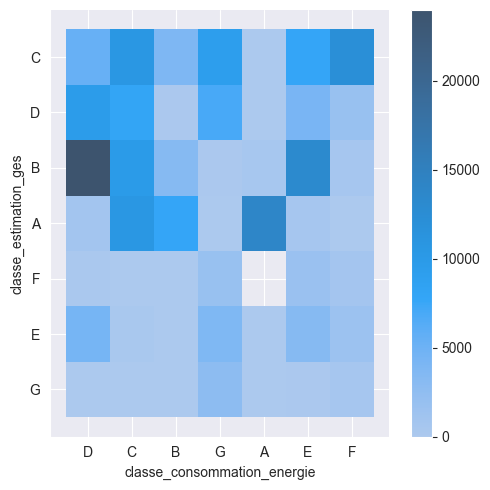

In [45]:
sns.displot(
    Y,
    x="classe_consommation_energie",
    y="classe_estimation_ges",
    row_order=["A", "B", "C", "D", "E", "F", "G", "H"],
    col_order=["A", "B", "C", "D", "E", "F", "G", "H"],
    cbar=True,
)
plt.show()

In [46]:
# Remove useless columns
X_filtered = X_train.drop(
    columns=[
        "commune",
        "arrondissement",
        "type_voie",
        "nom_rue",
        "numero_rue",
        "code_postal",
        "code_insee_commune",
        "code_insee_commune_actualise",
        "numero_lot",
        "nom_centre_commercial",
        "tr002_type_batiment_id",
        "secteur_activite",
        "tr012_categorie_erp_id",
        "tr013_type_erp_id",
        "tv016_departement_id",
        "batiment",
        "escalier",
        "etage",
        "porte",
        "quote_part",
        "portee_dpe_batiment",
        "partie_batiment",
        "en_souterrain",
        "en_surface",
        "nombre_circulations_verticales",  # faible variance
        "nombre_boutiques",  # faible variance"
        "presence_verriere",
        "type_vitrage_verriere",  # faible variance
        "etat_avancement",
        "adresse_organisme_certificateur",
        "dpe_vierge",  # faible variance
        "est_efface",  # faible variance
        "date_reception_dpe",  # date
        "geo_score",
        "geo_type",
        "geo_adresse",
        "geo_id",
        "geo_l4",
        "geo_l5",
        "tr002_type_batiment_code",
        "tr002_type_batiment_description",
        "tr002_type_batiment_libelle",
        "tr002_type_batiment_est_efface",
        "tr002_type_batiment_ordre",
        "tr002_type_batiment_simulateur",
        "tr012_categorie_erp_code",
        "tr012_categorie_erp_categorie",
        "tr012_categorie_erp_groupe",
        "tr012_categorie_erp_est_efface",
        "tr013_type_erp_code",
        "tr013_type_erp_type",
        "tr013_type_erp_categorie_id",
        "tr013_type_erp_est_efface",
        "tr013_type_erp_categorie",
        "tv016_departement_code",
        "tv016_departement_departement",
        "tv017_zone_hiver_id",
        "tv018_zone_ete_id",
        "tv016_departement_altmin",
        "tv016_departement_altmax",
        "tv016_departement_nref",
        "tv016_departement_dhref",
        "tv016_departement_pref",
        "tv016_departement_c2",
        "tv016_departement_c3",
        "tv016_departement_c4",
        "tv016_departement_t_ext_basse",
        "tv016_departement_e",
        "tv016_departement_fch",
        "tv016_departement_fecs_ancienne_m_i",
        "tv016_departement_fecs_recente_m_i",
        "tv016_departement_fecs_solaire_m_i",
        "tv016_departement_fecs_ancienne_i_c",
        "tv016_departement_fecs_recente_i_c",
        "tv017_zone_hiver_code",
        "tv017_zone_hiver_t_ext_moyen",
        "tv017_zone_hiver_peta_cw",
        "tv017_zone_hiver_dh14",
        "tv017_zone_hiver_prs1",
        "tv018_zone_ete_code",
        "tv018_zone_ete_sclim_inf_150",
        "tv018_zone_ete_sclim_sup_150",
        "tv018_zone_ete_rclim_autres_etages",
        "tv018_zone_ete_rclim_dernier_etage",
    ]
)

# list of columns to convert to float which is replacing a "\N" to "0.00" among possible values
nan_to_clean = [
    "surface_parois_verticales_opaques_deperditives",
    "surface_planchers_bas_deperditifs",
    "surface_planchers_hauts_deperditifs",
    "surface_baies_orientees_sud",
    "surface_baies_orientees_est_ouest",
    "surface_baies_orientees_nord",
    "nombre_entrees_sans_sas",
    "nombre_entrees_avec_sas",
    "surface_verriere",
    "nombre_niveaux",
    "surface_utile",
    "shon",
    "surface_commerciale_contractuelle",
    "surface_thermique_lot",
    "surface_habitable",
    "surface_thermique_parties_communes",
]
for col in nan_to_clean:
    X_filtered[col] = X_filtered[col].replace(r"\N", "0.00")
    X_filtered[col] = X_filtered[col].replace(",", "")  # clean the decimals
    X_filtered[col] = pd.to_numeric(X_filtered[col], errors="coerce")

# Replace NaN by mean for 'surface_commerciale_contractuelle'
X_filtered["surface_commerciale_contractuelle"] = X_filtered[
    "surface_commerciale_contractuelle"
].fillna(X_filtered["surface_commerciale_contractuelle"].mean())

X_filtered.shape

(130937, 19)

In [47]:
X_filtered.head()

,annee_construction,surface_habitable,surface_thermique_lot,surface_commerciale_contractuelle,shon,surface_utile,surface_thermique_parties_communes,nombre_niveaux,surface_verriere,nombre_entrees_avec_sas,nombre_entrees_sans_sas,surface_baies_orientees_nord,surface_baies_orientees_est_ouest,surface_baies_orientees_sud,surface_planchers_hauts_deperditifs,surface_planchers_bas_deperditifs,surface_parois_verticales_opaques_deperditives,longitude,latitude
id,,,,,,,,,,,,,,,,,,,
10408629,1947,110.00,110.00,0.000000,0.0,100.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.391482,50.638385
48420,1974,164.24,164.24,5.978682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.382002,51.000695
7710054,1947,164.56,164.56,0.000000,149.6,100.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.360872,48.857859
11399812,1970,0.00,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.065088,49.429748
7837691,1980,0.00,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.908481,45.052505


In [48]:
X_filtered.dtypes

annee_construction                                  int64
surface_habitable                                 float64
surface_thermique_lot                             float64
surface_commerciale_contractuelle                 float64
shon                                              float64
surface_utile                                     float64
surface_thermique_parties_communes                float64
nombre_niveaux                                    float64
surface_verriere                                  float64
nombre_entrees_avec_sas                           float64
nombre_entrees_sans_sas                           float64
surface_baies_orientees_nord                      float64
surface_baies_orientees_est_ouest                 float64
surface_baies_orientees_sud                       float64
surface_planchers_hauts_deperditifs               float64
surface_planchers_bas_deperditifs                 float64
surface_parois_verticales_opaques_deperditives    float64
longitude     